In [1]:
def flow_to_color(flow, max_flow=None):
    """
    将光流转换为彩色图像.
    
    参数:
      flow: numpy数组, 形状为 [H, W, 2], 表示每个像素点的光流向量 (u, v)
      max_flow: 可选, 用于归一化幅值的最大值。如果为None，则取当前光流的最大幅值
      
    返回:
      rgb图像: numpy数组, 形状为 [H, W, 3]
    """
    # 初始化 HSV 图像，H表示角度，S饱和度，V亮度
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    
    # 计算每个像素的幅值和角度（以弧度表示）
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    
    # 如果没有提供最大流，则取幅值的最大值用于归一化
    if max_flow is None:
        max_flow = np.max(mag)
    # 防止除零错误
    if max_flow == 0:
        max_flow = 1
    
    # 将角度转换到 [0,180] 的范围，用于 HSV 中 H 通道
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 1] = 255  # 饱和度设为最大
    # 将幅值归一化到 [0,255] 并赋值到 V 通道
    hsv[..., 2] = np.minimum(mag * 255 / max_flow, 255)
    
    # 将 HSV 图像转换为 RGB 图像
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return rgb

def display_forward_backward_flow(flow_tensor):
    """
    显示正向和反向光流.
    
    参数:
      flow_tensor: torch.Tensor, 形状为 [1, 2, H, W]
      
    功能:
      - 正向光流为原始光流.
      - 反向光流为原始光流的负，即运动方向相反.
      最后将二者转换为彩色图并并排显示.
    """
    # 将 tensor 转为 numpy 数组，并去除 batch 维度
    flow = flow_tensor.squeeze(0).detach().cpu().numpy()  # 结果形状: [2, H, W]
    # 调整维度顺序为 [H, W, 2]
    flow = np.transpose(flow, (1, 2, 0))
    
    # 正向光流: 原始光流
    forward_flow = flow
    # 反向光流: 每个向量取负
    backward_flow = -flow
    
    # 将光流转换为彩色图像
    forward_img = flow_to_color(forward_flow)
    backward_img = flow_to_color(backward_flow)
    
    # 利用 matplotlib 显示图像
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title("postive")
    plt.imshow(forward_img)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("negative")
    plt.imshow(backward_img)
    plt.axis('off')
    
    plt.show()

In [2]:
import os
import numpy as np
import random
import torch
from torch.utils.data import Dataset
import cv2
import glob
from tqdm import tqdm


class TrainSet(Dataset):
    def __init__(self, args):

        self.args = args

        LR_list = sorted(glob.glob(os.path.join(args.dataset_root, args.dataset_name, 'train/LR', '*')))
        HR_list = sorted(glob.glob(os.path.join(args.dataset_root, args.dataset_name, 'train/HR', '*')))
        Ref_full_list = sorted(glob.glob(os.path.join(args.dataset_root, args.dataset_name, 'train/Ref_full', '*')))
        self.scale = args.sr_scale

        self.LR_imgs = []
        self.HR_imgs = []
        self.Ref_full_imgs = []

        
        for i in tqdm(range(len(LR_list))):
            lr_img = cv2.imread(LR_list[i], -1)
            hr_img = cv2.imread(HR_list[i], -1)
            ref_img = cv2.imread(Ref_full_list[i], -1)
            if ref_img.shape[0] != lr_img.shape[0] * 2 or ref_img.shape[1] != lr_img.shape[1] * 2:
                print(f"索引 {i} 的图像尺寸不匹配：LR {lr_img.shape} vs Ref_SIFT {ref_img.shape}")
            self.LR_imgs.append(lr_img)
            self.HR_imgs.append(hr_img)
            self.Ref_full_imgs.append(ref_img)

    def __len__(self):
        return len(self.LR_imgs) * 50
    

    def crop_patch(self, LR, HR, Ref_full, p):
        # 获取 LR 与 Ref_full 的尺寸
        lr_h, lr_w = LR.shape[:2]
        ref_h, ref_w = Ref_full.shape[:2]
        lr_center_h, lr_center_w = ref_h // 2, ref_w // 2
        lr_center_start_y = (lr_h - lr_center_h) // 2
        lr_center_start_x = (lr_w - lr_center_w) // 2
        max_y = ref_h - p
        max_x = ref_w - p
        # 随机生成起始坐标
        rand_y = np.random.randint(0, max_y + 1)
        rand_x = np.random.randint(0, max_x + 1)
        # 在 Ref_full 上选择一个补丁（这里简单以 Ref_full 的中心为例）
        ref_patch_start_y = rand_y
        ref_patch_start_x = rand_x
        half_p = p//2
        ref_patch = Ref_full[ref_patch_start_y+half_p:ref_patch_start_y +p+half_p,
                             ref_patch_start_x+half_p:ref_patch_start_x +p+half_p, :]
        lr_patch_start_y = lr_center_start_y + (ref_patch_start_y // 2)
        lr_patch_start_x = lr_center_start_x + (ref_patch_start_x // 2)
        lr_patch = LR[lr_patch_start_y:lr_patch_start_y + p,
                      lr_patch_start_x:lr_patch_start_x + p, :]
        hr_patch = HR[lr_patch_start_y * 2 : (lr_patch_start_y + p) * 2,
              lr_patch_start_x * 2 : (lr_patch_start_x + p) * 2, :]
        #return lr  hr  lr_nearby  ref
        lr_patch_center = lr_patch[p//4 : p//4 + p//2,
                           p//4 : p//4 + p//2, :] 
        
        return lr_patch,hr_patch, lr_patch_center, ref_patch
                
    def augment(self, *args, hflip=True, rot=True):
        hflip = hflip and random.random() < 0.5
        vflip = rot and random.random() < 0.5
        k1 = np.random.randint(0, 3)
        def _augment(img):
            if hflip: img = img[:, ::-1, :]
            if vflip: img = img[::-1, :, :]        
            
            img = np.rot90(img, k1)
            
            return img

        return [_augment(a) for a in args]


    def __getitem__(self, idx):

        idx = idx % len(self.LR_imgs)

        LR = self.LR_imgs[idx]
        HR = self.HR_imgs[idx]
        Ref_full = self.Ref_full_imgs[idx]


        lr, hr, lr_nearby, ref = self.crop_patch(LR, HR, Ref_full, p=self.args.patch_size)
        lr, hr, lr_nearby, ref = self.augment(lr, hr, lr_nearby, ref)

        sample = {
                    'lr': lr,
                    'lr_nearby': lr_nearby,
                    'ref': ref,
                    'hr': hr,
                }

        for key in sample.keys():
            sample[key] = sample[key].astype(np.float32) / 255.
            sample[key] = torch.from_numpy(sample[key]).permute(2, 0, 1).float()

        return sample



class TestSet_cache(Dataset):
    def __init__(self, args):
        LR_list = sorted(glob.glob(os.path.join(args.dataset_root, args.dataset_name, 'test/LR', '*')))
        HR_list = sorted(glob.glob(os.path.join(args.dataset_root, args.dataset_name, 'test/HR', '*')))
        LR_center_list = sorted(glob.glob(os.path.join(args.dataset_root, args.dataset_name, 'test/LR_center', '*')))
        Ref_SIFT_list = sorted(glob.glob(os.path.join(args.dataset_root, args.dataset_name, 'test/Ref_SIFT', '*')))
        self.scale = args.sr_scale
        self.LR_imgs = []
        self.HR_imgs = []
        self.LR_center_imgs = []
        self.Ref_SIFT_imgs = []
        self.names = []


        for i in range(len(LR_list)):
            self.names.append(os.path.basename(LR_list[i]))
            lr_img = cv2.imread(LR_list[i], -1)
            ref_sift_img = cv2.imread(Ref_SIFT_list[i], -1)
            if ref_sift_img.shape[0] != lr_img.shape[0] or ref_sift_img.shape[1] != lr_img.shape[1]:
                print(f"索引 {i} 的图像尺寸不匹配：LR {lr_img.shape} vs Ref_SIFT {ref_sift_img.shape}")
            self.LR_imgs.append(lr_img)
            self.Ref_SIFT_imgs.append(ref_sift_img)
            self.HR_imgs.append(cv2.imread(HR_list[i], -1))
            self.LR_center_imgs.append(cv2.imread(LR_center_list[i], -1))

    def __len__(self):
        return len(self.LR_imgs)


    def __getitem__(self, idx):

        sample = {'LR': self.LR_imgs[idx],
                 'HR': self.HR_imgs[idx],               
                  'LR_center': self.LR_center_imgs[idx],
                  'Ref_SIFT': self.Ref_SIFT_imgs[idx],
                  }
        for key in sample.keys():
            sample[key] = sample[key].astype(np.float32) / 255.
            sample[key] = torch.from_numpy(sample[key]).permute(2, 0, 1).float()
        sample['name'] = self.names[idx]
        return sample


In [3]:
class Args:
    def __init__(self):
        # 数据集相关
        self.dataset_root = '/root/autodl-tmp/reproduce/KeDuSR/dataset'  # 数据集根目录
        self.dataset_name = 'CameraFusion-Real'  # 数据集名称
        self.sr_scale = 2  # 超分辨率缩放因子
        self.patch_size = 128  # 训练时的patch大小
        
        self.chunk_size = 128  # 测试时的分块大小
        
        self.use_tb_logger = True  # 是否使用tensorboard
        self.loss_Charbonnier = True  # 是否使用Charbonnier损失
        self.loss_perceptual = True  # 是否使用感知损失
        self.loss_cpen = True  # 是否使用CPEN损失

        # 模型相关
        self.pretrained = True  # 是否使用预训练模型
        self.resume = 'weights/20250301_002636/snapshot/net_best.pth'  # 恢复训练的权重文件路径

# 创建args实例
args = Args()

In [10]:
from torchvision.models.optical_flow import raft_large
device = 'cuda'
model = raft_large(pretrained=True, progress=False).to(device)
model = model.eval()
train_set = TestSet_cache(args)

/root/miniconda3/envs/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Raft_Large_Weights.C_T_SKHT_V2`. You can also use `weights=Raft_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
for sample in train_set:
    print(sample['lr'].shape)
    print(sample['ref'].shape)
    assert sample['LR'].shape == sample['Ref_SIFT'].shape

KeyError: 'lr'

In [14]:
for sample in train_set:
    print(sample['LR'].shape)
    print(sample['Ref_SIFT'].shape)
    assert sample['LR'].shape == sample['Ref_SIFT'].shape

torch.Size([3, 1280, 1792])
torch.Size([3, 1280, 1792])
torch.Size([3, 1280, 1792])
torch.Size([3, 1280, 1792])
torch.Size([3, 1792, 1280])
torch.Size([3, 1792, 1280])
torch.Size([3, 1792, 1280])
torch.Size([3, 1792, 1280])
torch.Size([3, 1280, 1792])
torch.Size([3, 1280, 1792])
torch.Size([3, 1280, 1792])
torch.Size([3, 1280, 1792])
torch.Size([3, 1280, 1792])
torch.Size([3, 1280, 1792])
torch.Size([3, 1280, 1792])
torch.Size([3, 1280, 1792])
torch.Size([3, 1280, 1792])
torch.Size([3, 1280, 1792])
torch.Size([3, 1280, 1792])
torch.Size([3, 1280, 1792])
torch.Size([3, 1280, 1792])
torch.Size([3, 1280, 1792])
torch.Size([3, 1792, 1280])
torch.Size([3, 1792, 1280])
torch.Size([3, 1280, 1792])
torch.Size([3, 1280, 1792])
torch.Size([3, 1280, 1792])
torch.Size([3, 1280, 1792])
torch.Size([3, 1280, 1792])
torch.Size([3, 1280, 1792])


In [7]:
import torch.nn.functional as F

class InputPadder:
    def __init__(self, dims, mode='sintel'):
        self.ht, self.wd = dims[-2:]
        pad_ht = (((self.ht // 8) + 1) * 8 - self.ht) % 8
        pad_wd = (((self.wd // 8) + 1) * 8 - self.wd) % 8
        if mode == 'sintel':
            self._pad = [pad_wd//2, pad_wd - pad_wd//2, pad_ht//2, pad_ht - pad_ht//2]
        else:
            self._pad = [pad_wd//2, pad_wd - pad_wd//2, 0, pad_ht]

    def pad(self, *inputs):
        return [F.pad(x, self._pad, mode='replicate') for x in inputs]

    def unpad(self,x):
        ht, wd = x.shape[-2:]
        c = [self._pad[2], ht-self._pad[3], self._pad[0], wd-self._pad[1]]
        return x[..., c[0]:c[1], c[2]:c[3]]

def predict_flow(model, image1, image2):
    model.eval()  # 确保模型处于评估模式
    image1 = image1.float()
    image2 = image2.float() 
    with torch.no_grad():
        padder = InputPadder(image1.shape) 
        image1, image2 = padder.pad(image1, image2)
        flow_predictions = model(image1, image2)
        flow = flow_predictions[-1]   
        flow = padder.unpad(flow)   
    return flow

def warp_image(image, flow):
    B, C, H, W = image.shape
    grid_y, grid_x = torch.meshgrid(torch.arange(0, H), torch.arange(0, W), indexing='ij')  # 适用于 PyTorch 1.10+
    grid_x = grid_x.to(image.device).float()
    grid_y = grid_y.to(image.device).float()
    norm_x = 2.0 * (grid_x + flow[:, 0, :, :]) / (W - 1) - 1.0
    norm_y = 2.0 * (grid_y + flow[:, 1, :, :]) / (H - 1) - 1.0
    grid = torch.stack((norm_x, norm_y), dim=-1)  # 形状 [B, H, W, 2]
    warped_image = F.grid_sample(image, grid, mode='bilinear', padding_mode='border', align_corners=True)
    return warped_image

import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def show_images(original, warped,titile_1, title_2):
    original = TF.to_pil_image(original.squeeze(0).cpu())  # 取第一个 batch，转换为 PIL
    warped = TF.to_pil_image(warped.squeeze(0).cpu())

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title(titile_1)
    
    plt.subplot(1, 2, 2)
    plt.imshow(warped)
    plt.title(title_2)

    plt.show()




torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 256, 256])


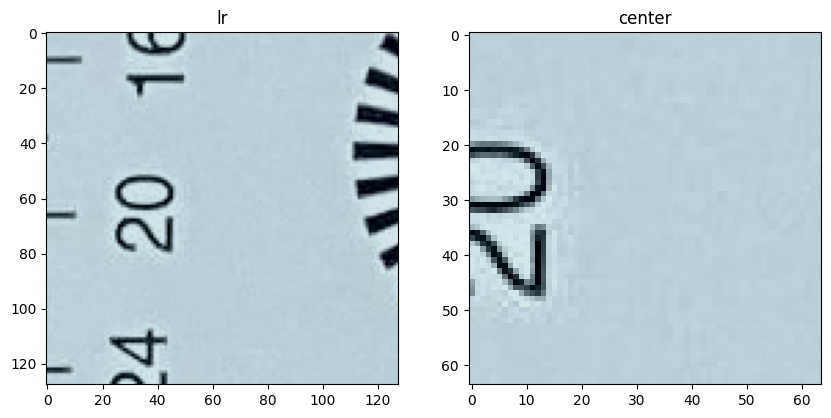

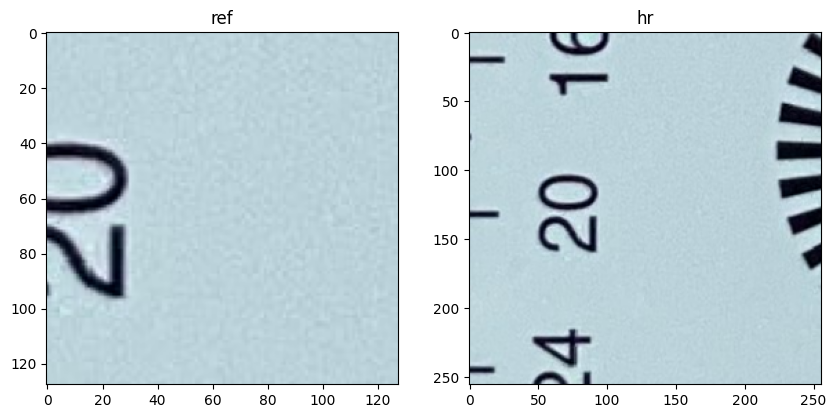

In [9]:
sample = train_set.__getitem__(1)
lr = sample['lr'].unsqueeze(0)  # 添加batch维度
lr_nearby = sample['lr_nearby'].unsqueeze(0)  # 添加batch维度
ref = sample['ref'].unsqueeze(0)  # 添加batch维度
hr = sample['hr'].unsqueeze(0)  # 添加batch维度
print(lr.shape)  # 打印形状
print(lr_nearby.shape)  # 打印形状
print(ref.shape)  # 打印形状
print(hr.shape)  # 打印形状
show_images(lr,lr_nearby,"lr","center")
show_images(ref,hr,"ref","hr")

In [33]:
lr_nearby_up = F.interpolate(lr_nearby.cuda(), scale_factor=2, mode='bilinear', align_corners=True)
flow = predict_flow(model.cuda(), lr_nearby_up.cuda(),ref.cuda())
flow.shape

torch.Size([1, 2, 256, 256])

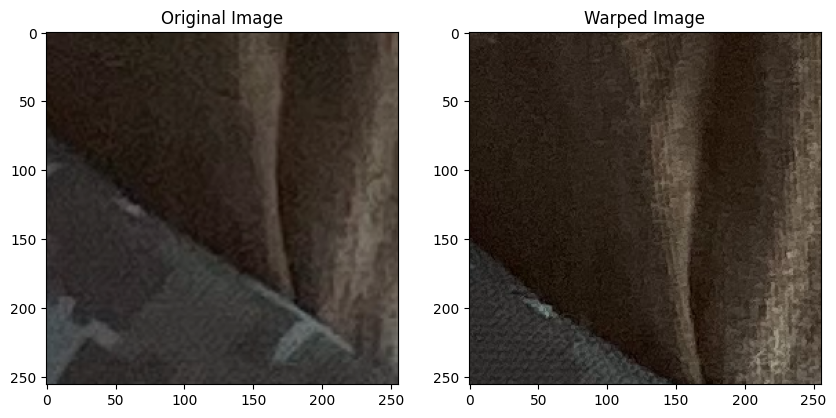

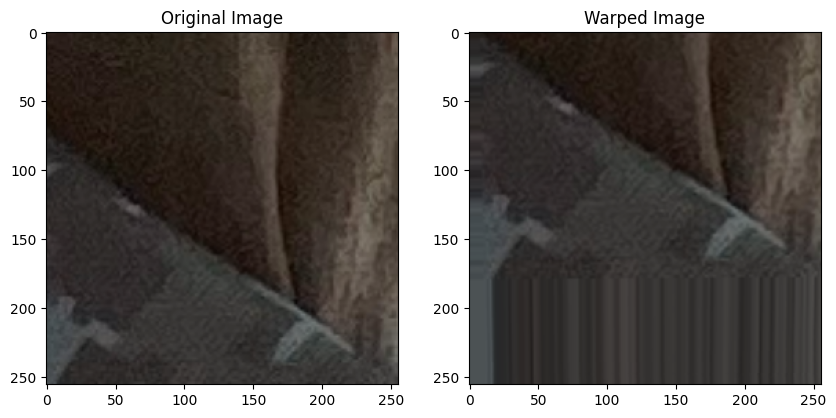

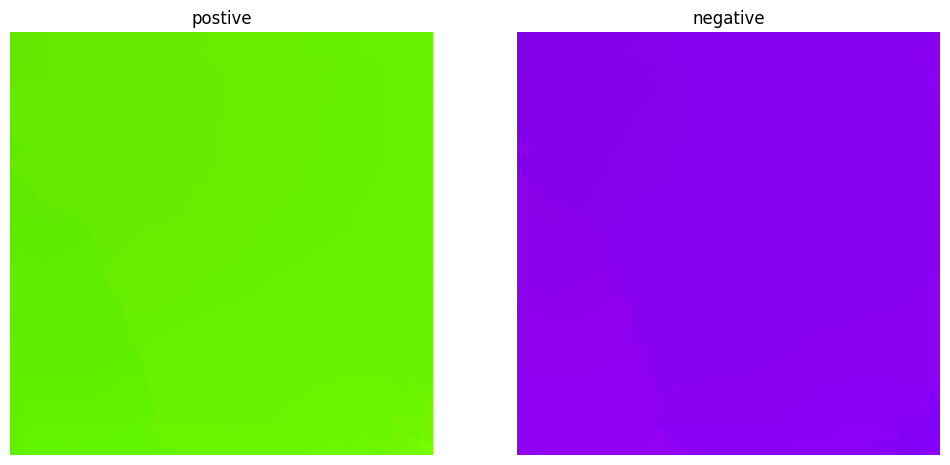

In [34]:
warped_image = warp_image(lr_nearby_up, flow)
show_images(lr_nearby_up,ref)
show_images(lr_nearby_up,warped_image)
display_forward_backward_flow(flow)

torch.Size([1, 3, 1560, 1560])
